Accuracy (Threshold=0.4695): 0.6286

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.42      0.46        26
           1       0.69      0.75      0.72        44

    accuracy                           0.63        70
   macro avg       0.59      0.59      0.59        70
weighted avg       0.62      0.63      0.62        70

Confusion Matrix:
 [[11 15]
 [11 33]]
Latitude          0.301407
Longitude         0.229244
pH Level          0.151504
SST_Change        0.122581
DHW_Cumulative    0.078059
DHW_Rolling12     0.063811
Month             0.037573
DHW               0.015822
dtype: float64


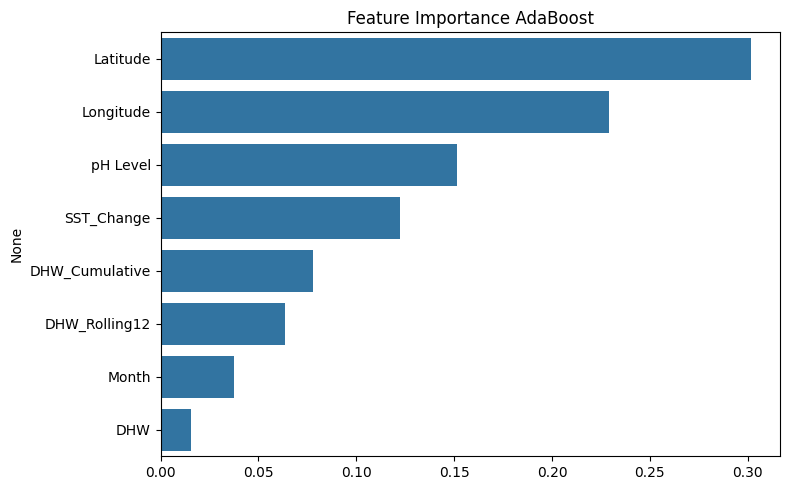

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. data reading
df = pd.read_excel('/content/total dataset.xlsx')


# 2. remove NaN & binary classification targeting
df_model = df.dropna(subset=["Bleaching Severity"]).copy()

le = LabelEncoder()
df_model["Bleaching Severity"] = le.fit_transform(df_model["Bleaching Severity"].astype(str))

high_label = le.transform(["High", "Medium"])
df_model["Bleaching_Binary"] = df_model["Bleaching Severity"].apply(lambda x: 1 if x in high_label else 0)


# 3. Input & output variables
features = ['Latitude', 'Longitude', 'pH Level', 'Month',
             'DHW', 'DHW_Rolling12','DHW_Cumulative', 'SST_Change']
X = df_model[features]
y = df_model["Bleaching_Binary"]

# 4.Data division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#5. UnderSampling
df_train = X_train.copy()
df_train['target'] = y_train

min_class_size = df_train['target'].value_counts().min()

df_under = df_train.groupby('target').sample(n=min_class_size, random_state=42)

X_under = df_under.drop(columns='target')
y_under = df_under['target']

#6. Adaboost ML
base = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight = 'balanced')
model_under = AdaBoostClassifier(estimator=base, n_estimators=200, random_state=42)
model_under.fit(X_under, y_under)

y_pred_under = model_under.predict(X_test)
y_proba_under = model_under.predict_proba(X_test)[:, 1]
acc_under = accuracy_score(y_test, y_pred_under)


# 7.probability precision & Threshold adjust
threshold = 0.4695
y_pred_thresh_under = (y_proba_under >= threshold).astype(int)


# 8. Evaluation
acc = accuracy_score(y_test, y_pred_thresh_under)
report = classification_report(y_test, y_pred_thresh_under)
conf = confusion_matrix(y_test, y_pred_thresh_under)

print(f"Accuracy (Threshold={threshold}): {acc:.4f}\n")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf)


# 8. Feature Importance 시각화
importances = pd.Series(model_under.feature_importances_, index=features).sort_values(ascending=False)
print(importances)
plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance AdaBoost')
plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
import numpy as np

# Search across [0, 1] threshold range in 1000 steps
search_range = np.linspace(0.0, 1.0, 1000)

# Condition settings
negative_total = sum(y_test == 0)

# At least 35% of negative samples must be correctly predicted
tn_min = int(negative_total * 0.35)
precision_min = 0.5
best_f1 = 0
best_threshold = 0.5

# Begin threshold search
for t in search_range:
    y_pred = (y_proba_under >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)

    if tn >= tn_min and precision >= precision_min:
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t


# Final application and output
y_pred_best = (y_proba_under >= best_threshold).astype(int)

acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
f1 = f1_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)

print(f"\nOptimal Threshold for F1: {best_threshold:.4f}")
print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {best_f1:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))



Optimal Threshold for F1: 0.4695

Accuracy:  0.6286
Precision: 0.6875
Recall:    0.7500
F1 Score:  0.7174

Confusion Matrix:
 [[11 15]
 [11 33]]


아래부터는 SHAP분석 코드

In [3]:
!pip install shap folium --quiet

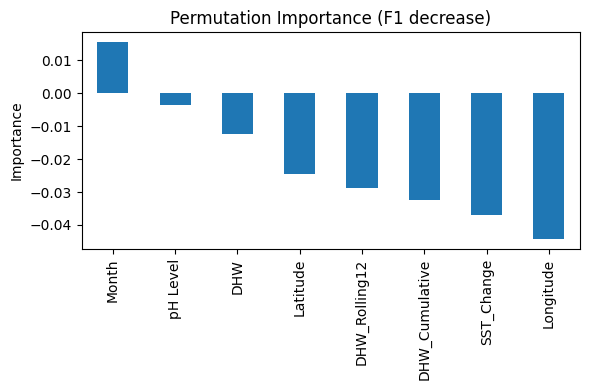

ExactExplainer explainer: 71it [00:25,  2.08it/s]


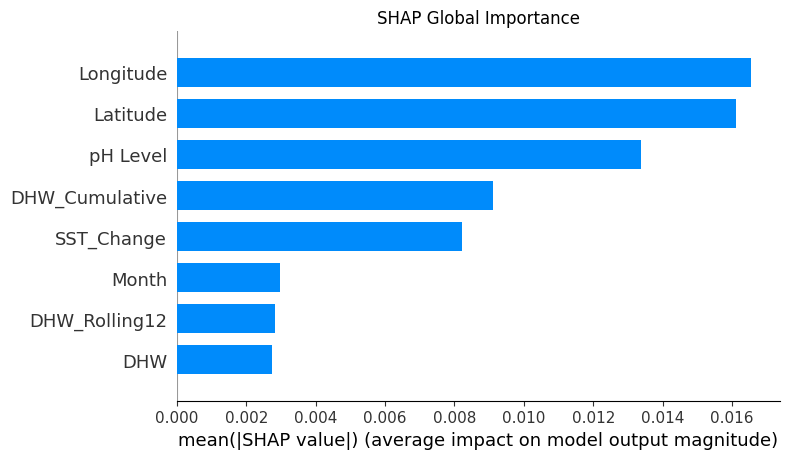

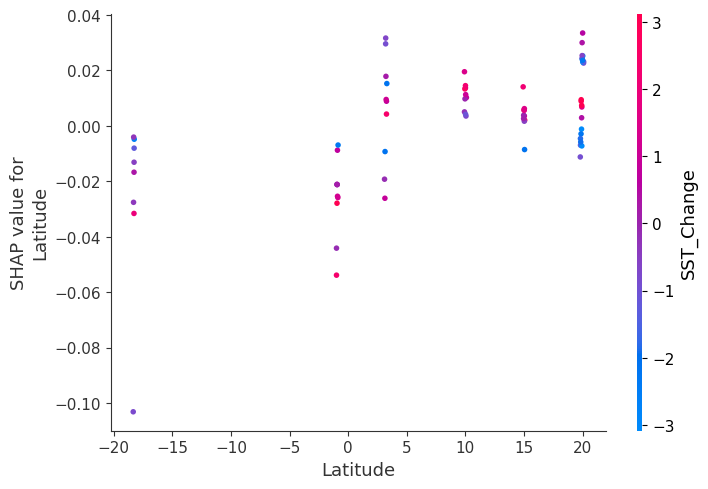

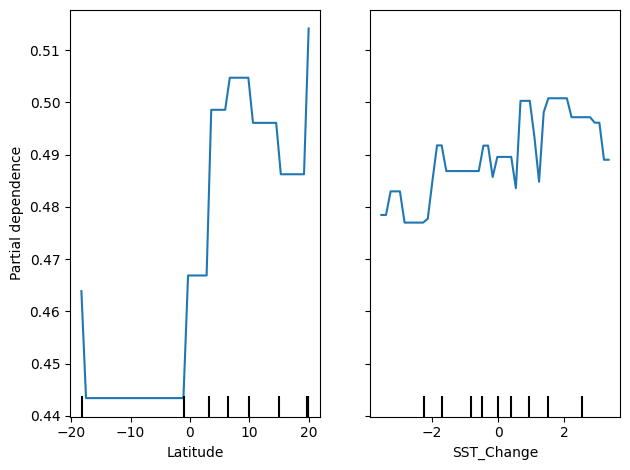

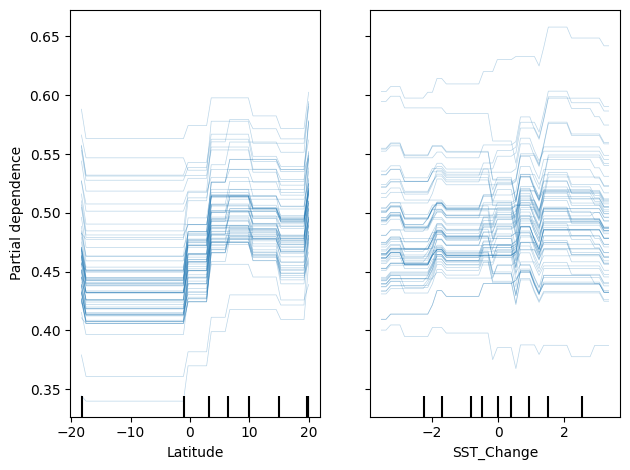

In [4]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from matplotlib import cm

perm = permutation_importance(model_under, X_test, y_test,
                              n_repeats=30, random_state=42, scoring='f1')
perm_series = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
perm_series.plot.bar()
plt.title("Permutation Importance (F1 decrease)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 8. SHAP 분석
explainer = shap.Explainer(lambda x: model_under.predict_proba(x)[:, 1], X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Importance")
plt.tight_layout()
plt.show()

shap.dependence_plot("Latitude", shap_values.values, X_test, show=False)
plt.tight_layout()
plt.show()

# 9. Partial Dependence & ICE
PartialDependenceDisplay.from_estimator(
    model_under, X_test,
    features=["Latitude","SST_Change"],
    kind="average", grid_resolution=50
)
plt.tight_layout()
plt.show()
PartialDependenceDisplay.from_estimator(
    model_under, X_test,
    features=["Latitude","SST_Change"],
    kind="individual", grid_resolution=50,
    subsample=100, random_state=42
)
plt.tight_layout()
plt.show()

#10
try:
    latitude_feature_index = features.index("Latitude")
    lat_shap = shap_values.values[:, latitude_feature_index]
except ValueError:
    print("Latitude feature not found in the features list.")
    lat_shap = None

if lat_shap is not None:
    m = folium.Map(
        location=[X_test["Latitude"].mean(), X_test["Longitude"].mean()],
        zoom_start=3
    )
    norm = plt.Normalize(lat_shap.min(), lat_shap.max())

    cmap = plt.colormaps["RdYlBu_r"]
    for (lat, lon), val in zip(X_test[["Latitude","Longitude"]].values, lat_shap):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color=cm.colors.to_hex(cmap(norm(val))),
            fill=True, fill_opacity=0.7
        ).add_to(m)
    m.save("shap_geo.html")
else:
    print("Geographic SHAP visualization skipped due to missing Latitude feature.")

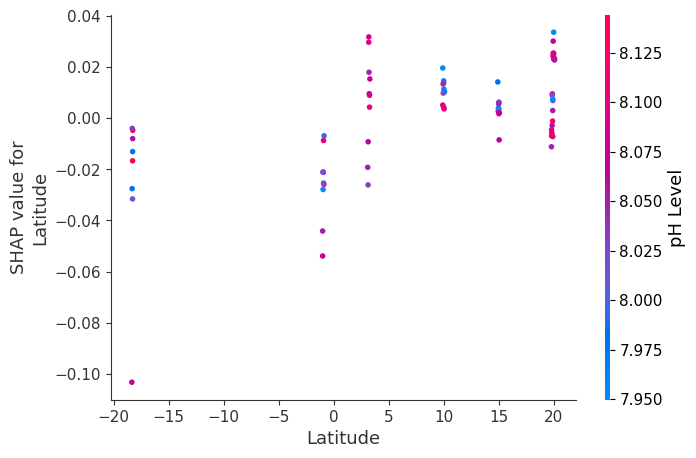

In [ ]:
shap.dependence_plot(
    "Latitude", shap_values.values, X_test,
    interaction_index="pH Level", show=False
)

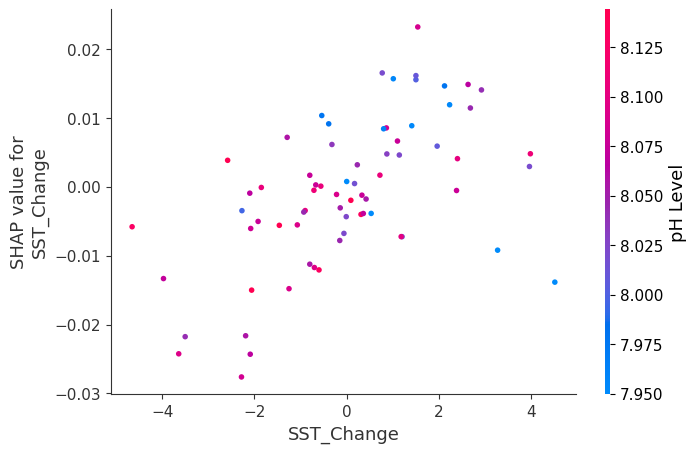

In [5]:
shap.dependence_plot(
    "SST_Change", shap_values.values, X_test,
    interaction_index="pH Level", show=False
)